The main code that was used here was from the site: *https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html* by the author **Sasank Chilamkurthy**.

I added my code for preparing the data to be fed into the model. I modified some of the code to fit for the required task






In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import scipy.io as sio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Checked for the list of models.

In [ ]:
[model for model in dir(models)]

In [ ]:
# load .mat files
train = sio.loadmat('/content/drive/MyDrive/train_32x32.mat')
val = sio.loadmat('/content/drive/MyDrive/test_32x32.mat')

# access to the dict
x_train = train['X'] #images
y_train = train['y'] #labels of the train images
print('train len: '+ str(len(y_train)))
x_val = val['X'] #images
y_val = val['y'] #labels of the val images
print('val len: '+ str(len(y_val)))

In [ ]:
# save the images to the train folder with the labels subfolders
number_of_files = 0
for number_of_files in range(73256):
  im = Image.fromarray(x_train[:,:,:,number_of_files])
  im.save('/content/drive/MyDrive/SVHN_cropped/train/'+str(int(y_train[number_of_files])) + '/' +str(number_of_files+1) + '.jpg')

number_of_files = 0
# save the images to the val folder with the labels subfolders
for number_of_files in range(26031):
  im = Image.fromarray(x_val[:,:,:,number_of_files])
  im.save('/content/drive/MyDrive/SVHN_cropped/val/'+str(int(y_val[number_of_files])) + '/' +str(number_of_files+1) + '.jpg')

In [ ]:
number_files = 0
for numlabel in range(10):
  list = os.listdir('/content/drive/MyDrive/SVHN_cropped/val/' + str(numlabel + 1))
  number_files = number_files + len(list)
  print(len(list))
print(number_files)
number_files = 0

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/Digit Reading Files/Digits Dataset'
#data_dir = '/content/drive/MyDrive/SVHN_small'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Check for the device if cuda or cpu.

In [ ]:
print(device)

cuda:0


Check the details of the nvidia cuda.

In [ ]:
!nvidia-smi

Check if cuda is available.

In [ ]:
torch.cuda.is_available()

Check what GPU is used.

In [ ]:
torch.cuda.get_device_name(0)

The code below shows some of the images and their corresponding labels.

The number of images depends on the batch_size.

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

The code below is for the training of the model. 

The number of epochs that I set was 25. 

Throughout the training process, the loss and acc values are shown per epoch. As the epoch further progresses, loss is decreased and acc is increased. This can be shown by the plots.

After the model is trained, the plots of the train loss, train acc, val loss, and val acc are shown.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_array_loss = []
    train_array_acc = []
    val_array_loss = []
    val_array_acc = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            #get details for plot
            if phase == 'train':
                train_array_loss.append(epoch_loss)
                train_array_acc.append(epoch_acc)
            if phase == 'val':
                val_array_loss.append(epoch_loss)
                val_array_acc.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # Print the plots of the loss and acc values for train and val
    #plt.subplot(1,2,1)
    plt.plot(train_array_loss, label = 'Train Loss')
    plt.plot(train_array_acc, label = 'Train Acc')
    plt.legend()
    plt.title('Train data loss and acc')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.show()
    #plt.subplot(1,2,2)
    plt.plot(val_array_loss, label = 'Val Loss')
    plt.plot(val_array_acc, label = 'Val Acc')
    plt.legend()
    plt.title('Val data loss and acc')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.show()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
  

    return model

The function below is for visualization purposes. We can see here the image and the predicted number of that image.

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# **Training of the three models**

---
The models used are:

*   resnet18
*   wide_resnet50_2
*   resnext50_32x4d

The models were trained with:

*   batch size = 1024
*   epoch = 25

The plots for the train loss/accuracy and val loss/accuracy are shown after the 25 epochs are completed.

# **resnext50_32x4d model**

In [ ]:
model_ft = models.resnext50_32x4d(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Training resnext50_32x4d model..
Epoch 0/24
----------
train Loss: 1.2249 Acc: 0.5848
val Loss: 0.6096 Acc: 0.8084

Epoch 1/24
----------
train Loss: 0.4597 Acc: 0.8545
val Loss: 0.3398 Acc: 0.9042

Epoch 2/24
----------
train Loss: 0.2133 Acc: 0.9366
val Loss: 0.2744 Acc: 0.9234

Epoch 3/24
----------
train Loss: 0.1525 Acc: 0.9522
val Loss: 0.2493 Acc: 0.9310

Epoch 4/24
----------
train Loss: 0.1294 Acc: 0.9582
val Loss: 0.2524 Acc: 0.9303

Epoch 5/24
----------
train Loss: 0.0895 Acc: 0.9722
val Loss: 0.2749 Acc: 0.9318

Epoch 6/24
----------
train Loss: 0.0717 Acc: 0.9784
val Loss: 0.2463 Acc: 0.9303

Epoch 7/24
----------
train Loss: 0.0439 Acc: 0.9860
val Loss: 0.2385 Acc: 0.9402

Epoch 8/24
----------
train Loss: 0.0325 Acc: 0.9926
val Loss: 0.2416 Acc: 0.9372

Epoch 9/24
----------
train Loss: 0.0329 Acc: 0.9930
val Loss: 0.2192 Acc: 0.9387

Epoch 10/24
----------
train Loss: 0.0308 Acc: 0.9914
val Loss: 0.2236 Acc: 0.9387

Epoch 11/24
----------
train Loss: 0.0178 Acc: 0.9962

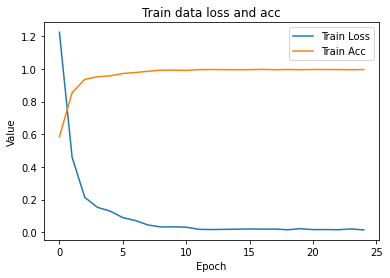

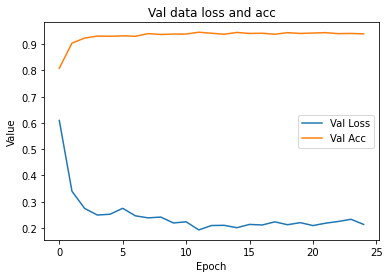

Training complete in 10m 45s
Best val Acc: 0.945594


In [ ]:
print('Training resnext50_32x4d model..')
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

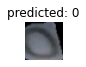

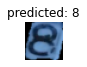

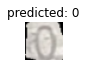

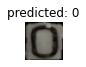

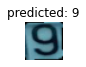

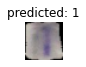

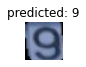

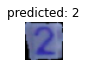

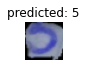

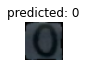

In [ ]:
visualize_model(model_ft)

The codes below is for saving the model.

In [ ]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

In [ ]:
filepath = '/content/drive/MyDrive/Digit Reading Files/digit_reading_model.pt'
torch.save(model_ft, filepath)
#torch.save(model_ft.state_dict(), filepath)